# Exploration03 - 스티커 붙히기 - 얼굴 각도를 옆으로 찍은 사진

## 패키지 import

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 이미지 불러오기

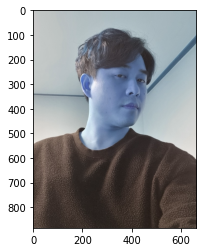

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/side2.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_original = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

opencv에서는 색상을 BGR 순으로 사용하기 때문에 색상이 원본과 다르게 보임  
(matplotlib, dlib 등은 RGB 순으로 사용)

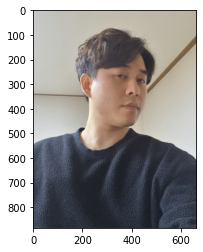

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 얼굴에서의 bounding box 추출

In [4]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
# dlib_rects = detector_hog(img_rgb, 1)

In [5]:
# img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(260, 171) (527, 439)]]


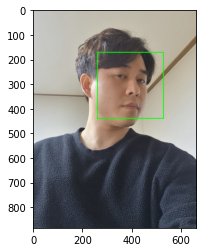

In [6]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_original, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_original_rgb =  cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
plt.imshow(img_original_rgb)
plt.show()

## 랜드마크 불러오기

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


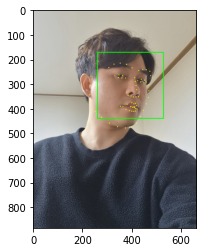

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_original, point, 2, (0, 255, 255), -1)

img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
plt.imshow(img_original_rgb)
plt.show()

랜드마크는 0번부터 67번까지 총 68개가 있음

## 스티커 붙히기

### 1. 스티커 붙힐 좌표 파악

코 끝을 기준으로 문제를 풀어가려고 함
- 코 끝의 인덱스 번호 : 33

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1]
    w = dlib_rect.width()
    h = dlib_rect.height()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(406, 352)
(x,y) : (406,352)
(w,h) : (268,269)


### 2. 스티커 불러오고 사이즈 조정

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(269, 268, 3)


사이즈는 bounding box의 w,h을 기준으로 조정함

### 3. 스티커 붙일 좌표 파악하기
- 스티커 이미지의 시작점은 top-left 좌표

In [12]:
re_x = x - w // 2
re_y = y - h // 2
print ('(x,y) : (%d,%d)'%(re_x, re_y))

(x,y) : (272,218)


스티커의 좌측 상단 좌표 : (272, 218)

### 4. 스티커가 이미지 범위를 넘어서는 영역 자름

In [13]:
if re_x < 0: 
    img_sticker = img_sticker[:, -re_x:]
    re_x = 0
if re_y < 0:
    img_sticker = img_sticker[-re_y:, :]
    re_y = 0

print ('(x,y) : (%d,%d)'%(re_x, re_y))

(x,y) : (272,218)


### 5. 스티커의 영역을 설정

In [14]:
img_sticker.shape

(269, 268, 3)

In [15]:
sticker_area = img_original[re_y: re_y + img_sticker.shape[0], re_x: re_x+img_sticker.shape[1]]
img_original[re_y: re_y + img_sticker.shape[0], re_x: re_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

고양이 수염의 배경이 흰색이고 수염이 투명이므로 img_sticker==255로 지정

### 6. 스티커 위치 확인

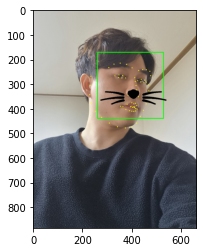

In [16]:
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
plt.show()

## 원본 이미지에 적용

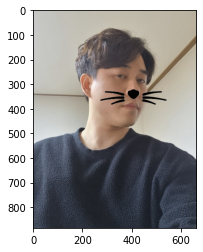

In [17]:
sticker_area = img_bgr[re_y: re_y + img_sticker.shape[0], re_x: re_x+img_sticker.shape[1]]
img_bgr[re_y: re_y + img_sticker.shape[0], re_x: re_x + img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 결과
- **각도를 틀어도 랜드마크가 잘 인식됨**
- 코끝에 고양이 수염 스티커가 잘 붙었음
- 스티커의 각도를 변경할 수 없어 아쉬움